# I. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

# II. Loading Data

#### CPI Historics Values

In [2]:
# Reading the CPI Historics Values data
cpi_values = pd.read_csv("CPI_Historic_Values_Zindi_May_23.csv")

# Changing the name of the Month column to Date
df = cpi_values.rename(columns={'Month': 'Date'})

# Chaning the format of the Date column
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Changing the name of "Percentage Change (From Prior Month)" column ot "Percentage_Change"
df = df.rename(columns={"Percentage Change (From Prior Month)":"Percentage_Change"})

# Setting the Date column as an index
df = df.set_index("Date")
df

,Category,Value,Percentage_Change
Date,,,
2023-05-31,Headline_CPI,109.6,0.2
2023-05-31,Food and non-alcoholic beverages,117.7,0.3
2023-05-31,Alcoholic beverages and tobacco,110.6,0.4
2023-05-31,Clothing and footwear,104.1,0.4
2023-05-31,Housing and utilities,104.6,0.0
...,...,...,...
2022-01-31,Communication,99.8,-0.2
2022-01-31,Recreation and culture,100.2,0.2
2022-01-31,Education,100.0,0.0


#### South African Benchmark Overnight Rate (SABOR) and Overnight Foreign Exchange (FX) Rate

In [3]:
# Reading the SABOR and FX data
sabor_fx = pd.read_csv("historical-data-sabor-June2023.csv", header=11)

# Kepping the values that we needed 
sabor_fx = sabor_fx.iloc[1:,:5]

# Changing the name of the first column to Date
sabor_fx.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

# Showing the data
sabor_fx

,Date,SABOR (%),Vol (Rmill),FX (%),Vol (Rmill)
1,"01-Aug-07,Wed",9.194,"R 67,642",10.636,"R 11,454"
2,"02-Aug-07,Thu",9.231,"R 65,447",11.760,"R 21,121"
3,"03-Aug-07,Fri",9.146,"R 66,296",9.715,"R 16,555"
4,"06-Aug-07,Mon",9.129,"R 67,565",9.428,"R 13,771"
5,"07-Aug-07,Tue",9.126,"R 63,059",9.444,"R 23,969"
...,...,...,...,...,...
4149,"26-Jun-23,Mon",8.218,"R 57,717",8.540,"R 4,052"
4150,"27-Jun-23,Tue",8.216,"R 54,911",8.570,"R 6,023"
4151,"28-Jun-23,Wed",8.206,"R 54,842",8.320,"R 4,789"
4152,"29-Jun-23,Thu",8.212,"R 52,438",8.430,"R 5,773"


In [4]:
# Extract month from the month of the "Date"
sabor_fx["Month"] = sabor_fx["Date"].str[3:-4]

# Convert the "Date" column to datetime format
sabor_fx["Date"] = pd.to_datetime(sabor_fx["Date"])

# Filter the DataFrame to include only rows with dates starting from '2021-12-01' to '2023-05-31'
sabor_fx = sabor_fx[(sabor_fx['Date'] >= '2021-12-01') & (sabor_fx['Date'] < '2023-06-01')]

# Rename columns " Vol (Rmill) " to "Vol (Rmill) 1" and "Vol (Rmill)" to "Vol (Rmill) 2"
sabor_fx.rename(columns={" Vol (Rmill) " : "Vol (Rmill) 1"}, inplace= True)
sabor_fx.rename(columns={"Vol (Rmill)" : "Vol (Rmill) 2"}, inplace= True)

# Replace commas with dots and remove the currency symbol from "Vol (Rmill) 1" column
sabor_fx["Vol (Rmill) 1"] = sabor_fx["Vol (Rmill) 1"].replace(',','.', regex=True)
sabor_fx["Vol (Rmill) 1"] = sabor_fx["Vol (Rmill) 1"].str[2:]

# Replace commas with dots and remove the currency symbol from "Vol (Rmill) 2" column
sabor_fx["Vol (Rmill) 2"] = sabor_fx["Vol (Rmill) 2"].replace(',','.', regex=True)
sabor_fx["Vol (Rmill) 2"] = sabor_fx["Vol (Rmill) 2"].str[2:]

# Group the DataFrame by "Month" and keep the last row for each month
grouped_sabor_fx = sabor_fx.groupby("Month").last()

# Sort the grouped DataFrame by "Date" in descending order
grouped_sabor_fx = grouped_sabor_fx.sort_values("Date", ascending=False)

# Showing the Data
grouped_sabor_fx

,Date,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Month,,,,,
May-23,2023-05-31,8.204,63.556,8.300,11.718
Apr-23,2023-04-28,7.732,60.571,8.490,4.757
Mar-23,2023-03-31,7.697,63.827,7.650,12.117
Feb-23,2023-02-28,7.222,57.714,7.850,12.143
Jan-23,2023-01-31,7.227,48.812,7.690,7.911
Dec-22,2022-12-30,6.964,45.351,7.200,10.915
Nov-22,2022-11-30,6.955,54.450,7.154,4.346
Oct-22,2022-10-31,6.194,59.099,6.200,8.171
Sep-22,2022-09-30,6.203,44.069,6.350,6.073


#### Joining All The Data Together 

In [5]:
# Get the column names of the features in grouped_sabor_fx DataFrame, excluding "Date"
sabor_features = grouped_sabor_fx.columns.drop("Date")


# Iterate over unique categories in the df DataFrame
for category in df.Category.unique():
   # Assign values from grouped_sabor_fx DataFrame to corresponding rows in df DataFrame for the specified category
   df.loc[df.Category == category,sabor_features] = grouped_sabor_fx.iloc[1:][sabor_features].values


# Convert "Vol (Rmill) 1" and "Vol (Rmill) 2" columns to float data type
df["Vol (Rmill) 1"] = df["Vol (Rmill) 1"].astype(float)
df["Vol (Rmill) 2"] = df["Vol (Rmill) 2"].astype(float)
df

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2023-05-31,Headline_CPI,109.6,0.2,7.732,60.571,8.49,4.757
2023-05-31,Food and non-alcoholic beverages,117.7,0.3,7.732,60.571,8.49,4.757
2023-05-31,Alcoholic beverages and tobacco,110.6,0.4,7.732,60.571,8.49,4.757
2023-05-31,Clothing and footwear,104.1,0.4,7.732,60.571,8.49,4.757
2023-05-31,Housing and utilities,104.6,0.0,7.732,60.571,8.49,4.757
...,...,...,...,...,...,...,...
2022-01-31,Communication,99.8,-0.2,3.865,36.634,6.60,4.380
2022-01-31,Recreation and culture,100.2,0.2,3.865,36.634,6.60,4.380
2022-01-31,Education,100.0,0.0,3.865,36.634,6.60,4.380


# III. Preparing Functions for our Analysis

In [6]:
def tsa_plots(df):

    """
    Plot the time serie with its corresponding AFC and PACF plots for a given DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the time series data.

    Returns:
        None (displays the plots)

    """
    
    # Create the subplots
    fig, ax = plt.subplots(3,1,figsize=(10, 15))

    #Plotting the Serie of the vlues of the category
    ax[0].plot(df.index, df.Value, linewidth=2)
    ax[0].set_title(df["Category"][0])
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Values')

    #Plotting the ACF of the serie 
    sgt.plot_acf(df["Value"], ax = ax[1], title= "ACF of "+ df["Category"][0])
    ax[1].set_xlabel("Nbr of lags")

    #Plotting the PACF of the serie
    sgt.plot_pacf(df["Value"],lags=7, ax=ax[2], title="PACF of "+ df["Category"][0])
    ax[2].set_xlabel("Nbr of lags")

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

In [7]:
def ADF_test(ts):
    
    """
    Perform the Augmented Dickey-Fuller (ADF) test on a given time series.

    Parameters:
        ts (array-like): The time series data to be tested.

    Returns:
        None (prints the test results and the stationary status of the time series)

    """

    # Perform the Augmented Dickey-Fuller (ADF) test on the given time series
    result = sts.adfuller(ts)

    # Print the test results
    print("-"*15, "Test Results","-"*15)
    print("The t-test:", "\t",result[0]) # Print the t-test statistic
    print("The p-value:","\t",result[1]) # Print the p-value
    print("-"*46)

    # Check the p-value and determine if the time series is stationary or not
    if result[1] < 0.05:
        print("The Time Serie is Stationary") # If p-value is less than 0.05, the time series is stationary
    else:
        print("The Time Serie is Not Stationary") # If p-value is greater than or equal to 0.05, the time series is not stationary

In [8]:
def arimax_model(df, order, trend=None,exog_features= None):
    
    """
    Fit and evaluate an ARIMAX model on a given DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing the time series data.
        order (tuple): The order of the ARIMA model (p, d, q).
        trend (str or None): The trend component to include in the model.
        exog_features (list or None): The names of the exogenous features to include in the model.

    Returns:
        model: The fitted ARIMAX model.

    """
    
    # Fit the ARIMAX model with the specified order, trend, and exogenous features (if provided)
    if exog_features:
        model = ARIMA(df["Value"], order = order, trend = trend, exog= df[exog_features])
    else:
        model = ARIMA(df["Value"], order = order, trend= trend)
    result = model.fit()

    # Display the summary of the fitted model
    display(result.summary())

    # TESTING
    print("-"*30,"TEST:","-"*30)

    # Split the DataFrame into training and test data
    train = df.iloc[:-1]
    test = df.iloc[-1]

    # Fit the ARIMAX model on the training data
    if exog_features:
        test_model = ARIMA(train.Value,order= order,trend=trend, exog=train[exog_features])
    else:
        test_model = ARIMA(train.Value,trend= trend, order= order)
    test_res = test_model.fit()

    # Display the summary of the test model
    display(test_res.summary())

    # Forecast the value for the test data point
    if exog_features:
        test_pred = test_res.forecast(exog=test[exog_features])[0]
    else:
        test_pred = test_res.forecast()[0]

    # Print the actual value, predicted value, and the error
    print(f"The test value:   \t {test.Value}")
    print(f"The predicted value: \t {test_pred}")
    print(f"The Error:         \t {test.Value - test_pred}")

    return model

In [9]:
def LLR_test(mod_1, mod_2, DF = 1):

    """
    Perform a likelihood ratio test between two models.

    Parameters:
        mod_1: The first model to compare.
        mod_2: The second model to compare.
        DF (int): Degrees of freedom for the test (default=1).

    Returns:
        p (float): The p-value of the likelihood ratio test.

    """
    # Fit the first model and obtain the log-likelihood
    L1 = mod_1.fit().llf

    # Fit the second model and obtain the log-likelihood
    L2 = mod_2.fit().llf

    # Calculate the likelihood ratio statistic
    LR = (2*(L2-L1))   

    # Calculate the p-value using the chi-square distribution 
    p = chi2.sf(LR, DF).round(3)

    # Return the p-value
    return p

In [10]:
def testing_features(df, order):
    """
    Fit and evaluate ARIMA models with different exogenous features.

    Parameters:
        df (DataFrame): The input DataFrame containing the time series data and exogenous features.
        order (tuple): The order of the ARIMA model (p, d, q).

    Returns:
        None (prints the evaluation results for each feature)

    """

    # Iterate over each column (exogenous feature) except for "Category", "Value", and "Percentage_Change"
    for col in df.columns.drop(["Category", "Value", "Percentage_Change"]):
        # Fit an ARIMA model with the specified order and the current exogenous feature
        model = ARIMA(df["Value"], order=order, exog=df[col])
        result = model.fit()
        
        # Split the DataFrame into training and test data
        train = df.iloc[:-1]
        test = df.iloc[-1]

        # Fit the ARIMAX model on the training data
        test_model = ARIMA(train.Value,order= order, exog=train[col])
        test_res = test_model.fit()
        test_pred = test_res.forecast(exog=test[col])[0]


        # Print the evaluation results for the current feature
        print(f"For the {col} feature:")
        print(f"LLR = {result.llf} \t AIC = {result.aic} \t BIC = {result.bic} \t Error = {test.Value - test_pred:.3f} \n")


In [11]:
def making_prediction(model, df_exog = None):

    """
    Make a prediction using a fitted ARIMA model.

    Parameters:
        model: The fitted ARIMA model.
        df_exog (DataFrame or None): The exogenous features for the prediction (default=None).

    Returns:
        float: The predicted value.

    """
    # Fit the model
    result = model.fit()

    # Make a prediction using the fitted model and the exogenous features (if provided)
    if df_exog:
        return result.forecast(exog= df_exog)[0]
    else:
        return result.forecast()[0]

# IV. Analysing Each Category and Building Models

In [12]:
# Create an empty dictionary to store predicted CPI data
cpi_dict = {}

## 1. Headline_CPI

In [13]:
headline_cpi = df[df["Category"]== "Headline_CPI"]
headline_cpi = headline_cpi.asfreq("M")
headline_cpi.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Headline_CPI,100.2,0.2,3.865,36.634,6.600,4.380
2022-02-28,Headline_CPI,100.8,0.6,4.041,51.326,5.250,5.237
2022-03-31,Headline_CPI,101.8,1.0,4.068,56.201,5.058,3.390
2022-04-30,Headline_CPI,102.4,0.6,4.243,53.542,4.241,8.107
2022-05-31,Headline_CPI,103.1,0.7,4.272,47.676,5.250,4.997


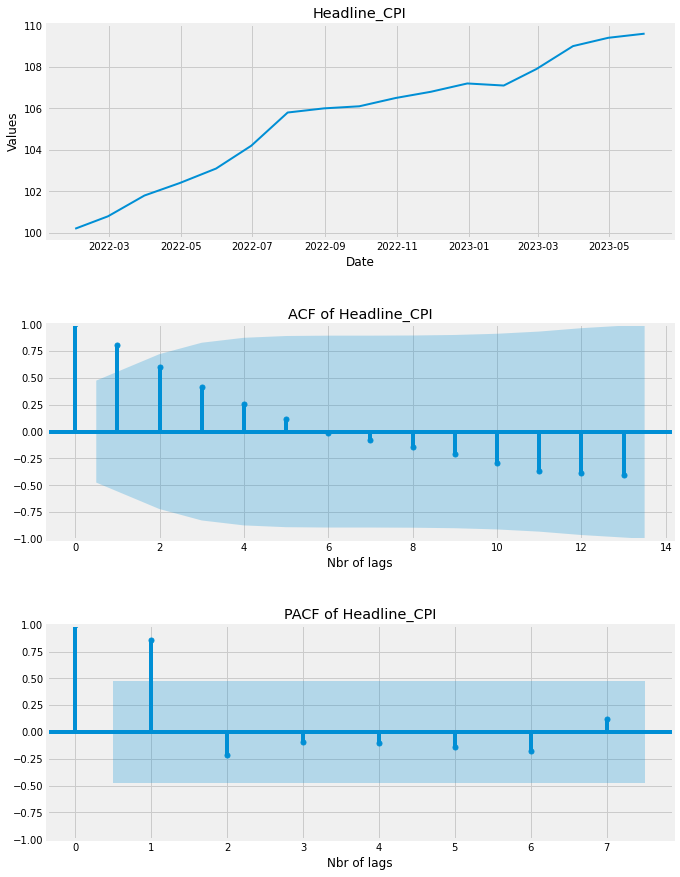

In [14]:
tsa_plots(headline_cpi)

In [15]:
ADF_test(headline_cpi.Value)

--------------- Test Results ---------------
The t-test: 	 -1.3053011918666113
The p-value: 	 0.6267435354878167
----------------------------------------------
The Time Serie is Not Stationary


In [16]:
model = arimax_model(headline_cpi,(1,1,1),exog_features="Vol (Rmill) 2")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -8.980
Date:                Mon, 24 Jul 2023   AIC                             25.960
Time:                        19:50:09   BIC                             29.051
Sample:                    01-31-2022   HQIC                            26.118
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Vol (Rmill) 2     0.0180      0.018      1.004      0.315      -0.017       0.053
ar.L1             0.9917      0.021     48.005      0.000       0.951       1.032
ma.L1            -0.8057      0.178     -4.534      0.000      -1.154      -0.457
sigma2            0.1593      0.087      1.837      0.066      -0.011       0.329
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.56   Prob(JB):                         0.69
Heteroskedasticity (H):               1.96   Skew:                            -0.41
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -8.850
Date:                Mon, 24 Jul 2023   AIC                             25.699
Time:                        19:50:09   BIC                             28.532
Sample:                    01-31-2022   HQIC                            25.669
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Vol (Rmill) 2     0.0175      0.018      0.975      0.330      -0.018       0.053
ar.L1             0.9928      0.019     50.959      0.000       0.955       1.031
ma.L1            -0.8179      0.185     -4.427      0.000      -1.180      -0.456
sigma2            0.1666      0.095      1.754      0.079      -0.020       0.353
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.56   Prob(JB):                         0.64
Heteroskedasticity (H):               1.91   Skew:                            -0.49
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 109.6
The predicted value: 	 109.80045997014093
The Error:         	 -0.2004599701409404


In [17]:
testing_features(headline_cpi,(1,1,1))

For the SABOR (%) feature:
LLR = -11.162180846709058 	 AIC = 30.324361693418115 	 BIC = 33.41471658237724 	 Error = -0.426 

For the Vol (Rmill) 1 feature:
LLR = -11.26122835856695 	 AIC = 30.5224567171339 	 BIC = 33.612811606093025 	 Error = -0.046 

For the FX (%)  feature:
LLR = -11.208689511981909 	 AIC = 30.417379023963818 	 BIC = 33.507733912922944 	 Error = -0.327 

For the Vol (Rmill) 2 feature:
LLR = -8.980093992810975 	 AIC = 25.96018798562195 	 BIC = 29.050542874581076 	 Error = -0.200 



In [18]:
exog_df = df["Vol (Rmill) 2"][0]
cpi_dict["Headline_CPI"] = making_prediction(model,exog_df)

## 2. Food and non-alcoholic beverages

In [19]:
food_non_alco = df[df["Category"]== "Food and non-alcoholic beverages"]
food_non_alco = food_non_alco.asfreq("M")
food_non_alco.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Food and non-alcoholic beverages,100.9,0.9,3.865,36.634,6.600,4.380
2022-02-28,Food and non-alcoholic beverages,101.8,0.9,4.041,51.326,5.250,5.237
2022-03-31,Food and non-alcoholic beverages,102.4,0.6,4.068,56.201,5.058,3.390
2022-04-30,Food and non-alcoholic beverages,103.1,0.7,4.243,53.542,4.241,8.107
2022-05-31,Food and non-alcoholic beverages,105.3,2.1,4.272,47.676,5.250,4.997


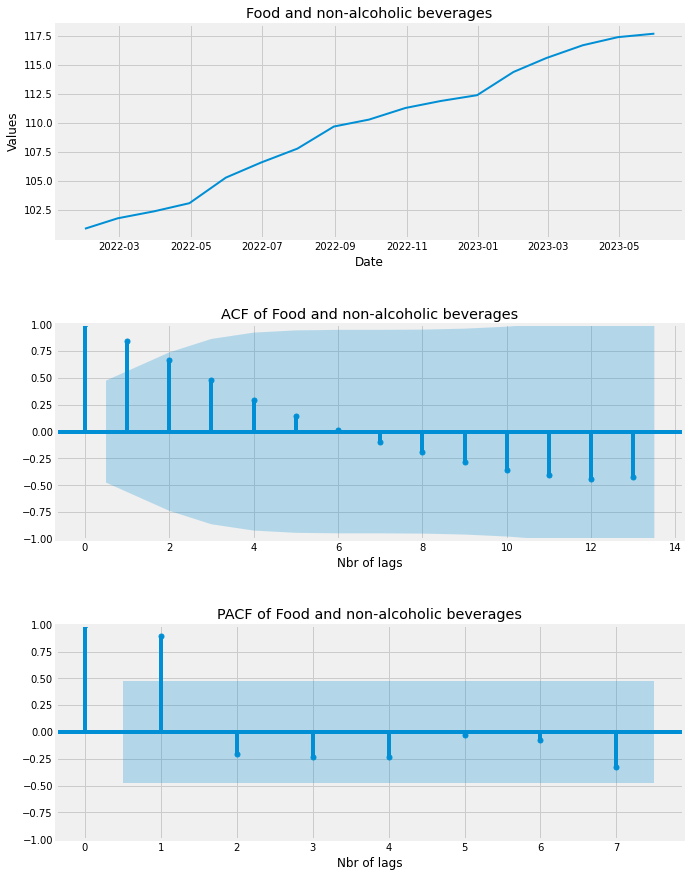

In [20]:
tsa_plots(food_non_alco)

In [21]:
ADF_test(food_non_alco.Value)

--------------- Test Results ---------------
The t-test: 	 -3.079429996191869
The p-value: 	 0.028113388381233482
----------------------------------------------
The Time Serie is Stationary


In [22]:
model = arimax_model(food_non_alco,(1,1,0))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -17.804
Date:                Mon, 24 Jul 2023   AIC                             39.608
Time:                        19:50:11   BIC                             41.153
Sample:                    01-31-2022   HQIC                            39.687
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7694      0.216      3.559      0.000       0.346       1.193
sigma2         0.5125      0.178      2.876      0.004       0.163       0.862
===================================================================================
Ljung-Box (L1) (Q):                   3.29   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.07   Prob(JB):                         0.43
Heteroskedasticity (H):               0.86   Skew:                             0.80
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -17.151
Date:                Mon, 24 Jul 2023   AIC                             38.301
Time:                        19:50:11   BIC                             39.718
Sample:                    01-31-2022   HQIC                            38.286
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7736      0.226      3.427      0.001       0.331       1.216
sigma2         0.5423      0.201      2.700      0.007       0.149       0.936
===================================================================================
Ljung-Box (L1) (Q):                   3.79   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.05   Prob(JB):                         0.54
Heteroskedasticity (H):               0.84   Skew:                             0.70
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 117.7
The predicted value: 	 117.94154376460128
The Error:         	 -0.2415437646012748


In [23]:
testing_features(food_non_alco,(1,1,0))

For the SABOR (%) feature:
LLR = -17.70709702066356 	 AIC = 41.41419404132712 	 BIC = 43.731960208046466 	 Error = -0.189 

For the Vol (Rmill) 1 feature:
LLR = -17.80336745521639 	 AIC = 41.60673491043278 	 BIC = 43.92450107715212 	 Error = -0.253 

For the FX (%)  feature:
LLR = -16.74606130780481 	 AIC = 39.49212261560962 	 BIC = 41.80988878232896 	 Error = -0.417 

For the Vol (Rmill) 2 feature:
LLR = -16.905971419126093 	 AIC = 39.811942838252186 	 BIC = 42.12970900497153 	 Error = -0.356 



In [24]:
cpi_dict["Food and non-alcoholic beverages"] = making_prediction(model)

## 3. Alcoholic beverages and tobacco

In [25]:
alco_tabacco = df[df["Category"]== "Alcoholic beverages and tobacco"]
alco_tabacco = alco_tabacco.asfreq("M")
alco_tabacco.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Alcoholic beverages and tobacco,100.0,0.0,3.865,36.634,6.600,4.380
2022-02-28,Alcoholic beverages and tobacco,100.6,0.6,4.041,51.326,5.250,5.237
2022-03-31,Alcoholic beverages and tobacco,102.8,2.2,4.068,56.201,5.058,3.390
2022-04-30,Alcoholic beverages and tobacco,103.6,0.8,4.243,53.542,4.241,8.107
2022-05-31,Alcoholic beverages and tobacco,104.4,0.8,4.272,47.676,5.250,4.997


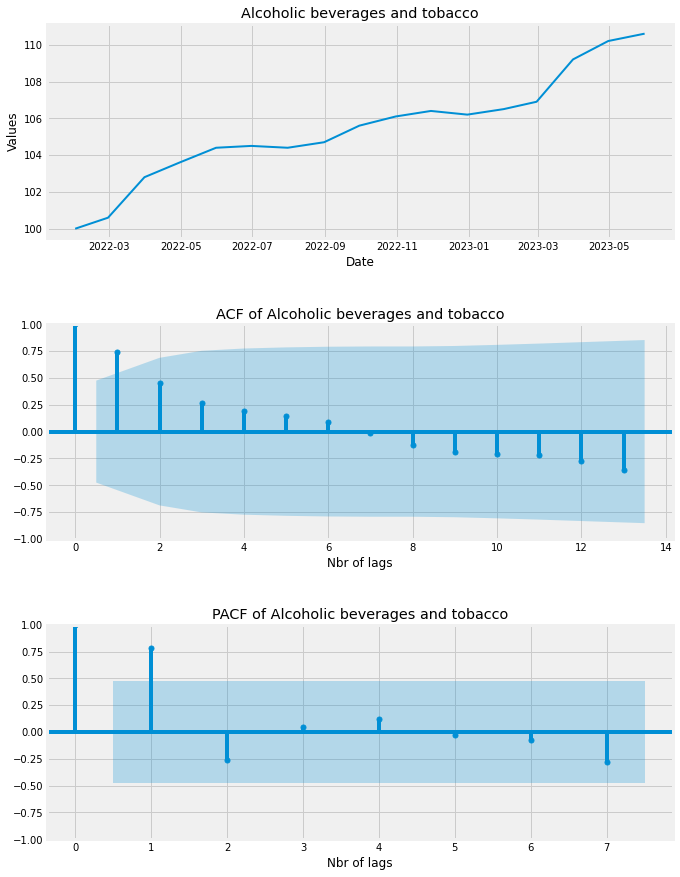

In [26]:
tsa_plots(alco_tabacco)

In [27]:
ADF_test(alco_tabacco.Value)

--------------- Test Results ---------------
The t-test: 	 -0.4186144468652039
The p-value: 	 0.9069441326227416
----------------------------------------------
The Time Serie is Not Stationary


In [28]:
ADF_test(alco_tabacco.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 -2.850903306430285
The p-value: 	 0.05136241210037407
----------------------------------------------
The Time Serie is Not Stationary


In [29]:
model = arimax_model(alco_tabacco, (1,1,1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -18.784
Date:                Mon, 24 Jul 2023   AIC                             43.569
Time:                        19:50:12   BIC                             45.887
Sample:                    01-31-2022   HQIC                            43.688
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6508      0.959      0.679      0.497      -1.229       2.530
ma.L1         -0.1314      1.300     -0.101      0.919      -2.680       2.417
sigma2         0.5980      0.240      2.495      0.013       0.128       1.068
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 6.00
Prob(Q):                              0.64   Prob(JB):                         0.05
Heteroskedasticity (H):               1.14   Skew:                             1.41
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -17.774
Date:                Mon, 24 Jul 2023   AIC                             41.549
Time:                        19:50:12   BIC                             43.673
Sample:                    01-31-2022   HQIC                            41.526
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.050     19.925      0.000       0.902       1.098
ma.L1         -0.9940      6.737     -0.148      0.883     -14.199      12.211
sigma2         0.5306      3.708      0.143      0.886      -6.738       7.799
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):                 3.57
Prob(Q):                              0.24   Prob(JB):                         0.17
Heteroskedasticity (H):               1.18   Skew:                             1.16
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 110.6
The predicted value: 	 110.82834750296037
The Error:         	 -0.22834750296037498


In [30]:
testing_features(alco_tabacco,(1,1,1))

For the SABOR (%) feature:
LLR = -18.40390927679405 	 AIC = 44.8078185535881 	 BIC = 47.898173442547225 	 Error = -0.407 

For the Vol (Rmill) 1 feature:
LLR = -18.665017141270965 	 AIC = 45.33003428254193 	 BIC = 48.42038917150106 	 Error = -0.152 

For the FX (%)  feature:
LLR = -18.765751353530145 	 AIC = 45.53150270706029 	 BIC = 48.62185759601942 	 Error = -0.158 

For the Vol (Rmill) 2 feature:
LLR = -18.784394108494315 	 AIC = 45.56878821698863 	 BIC = 48.659143105947756 	 Error = -0.249 



In [31]:
cpi_dict["Alcoholic beverages and tobacco"] = making_prediction(model)

## 4. Clothing and footwear

In [32]:
clothing_footwear = df[df["Category"]== "Clothing and footwear"]
clothing_footwear = clothing_footwear.asfreq("M")
clothing_footwear.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Clothing and footwear,100.2,0.2,3.865,36.634,6.600,4.380
2022-02-28,Clothing and footwear,100.3,0.1,4.041,51.326,5.250,5.237
2022-03-31,Clothing and footwear,100.5,0.2,4.068,56.201,5.058,3.390
2022-04-30,Clothing and footwear,100.7,0.2,4.243,53.542,4.241,8.107
2022-05-31,Clothing and footwear,100.9,0.2,4.272,47.676,5.250,4.997


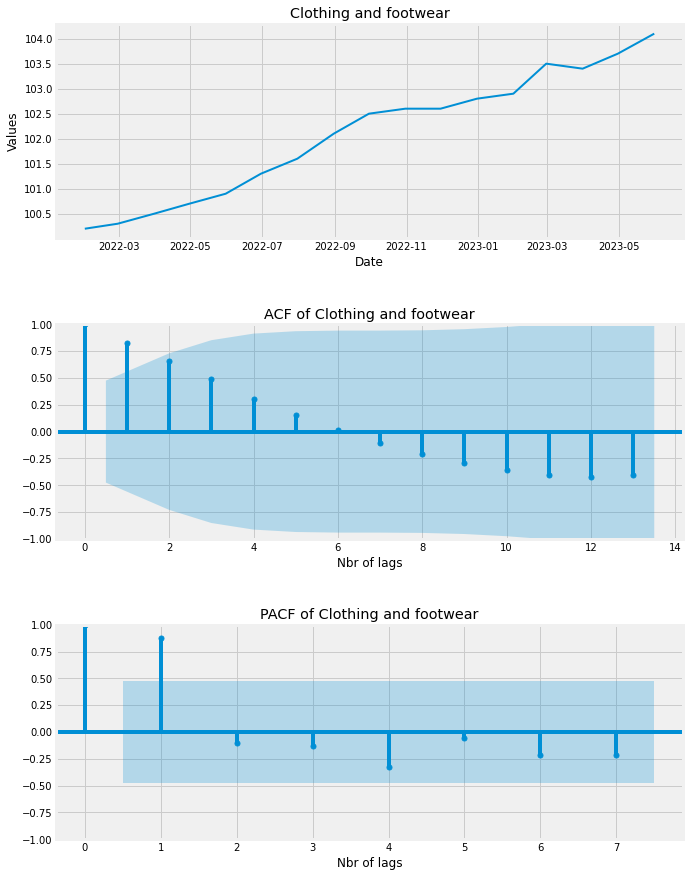

In [33]:
tsa_plots(clothing_footwear)

In [34]:
ADF_test(clothing_footwear.Value)

--------------- Test Results ---------------
The t-test: 	 -0.0588603557459687
The p-value: 	 0.9533851358765255
----------------------------------------------
The Time Serie is Not Stationary


In [35]:
ADF_test(clothing_footwear.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 -15.242586815084175
The p-value: 	 5.138318157713352e-28
----------------------------------------------
The Time Serie is Stationary


In [36]:
model = arimax_model(clothing_footwear,(1,1,1),exog_features="SABOR (%)")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   3.172
Date:                Mon, 24 Jul 2023   AIC                              1.657
Time:                        19:50:13   BIC                              4.747
Sample:                    01-31-2022   HQIC                             1.815
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SABOR (%)      0.1645      0.153      1.075      0.282      -0.136       0.465
ar.L1          0.9999      0.044     22.588      0.000       0.913       1.087
ma.L1         -0.9849      3.471     -0.284      0.777      -7.789       5.819
sigma2         0.0331      0.125      0.265      0.791      -0.212       0.278
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.86   Prob(JB):                         0.76
Heteroskedasticity (H):               5.09   Skew:                            -0.35
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   3.091
Date:                Mon, 24 Jul 2023   AIC                              1.818
Time:                        19:50:13   BIC                              4.650
Sample:                    01-31-2022   HQIC                             1.788
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SABOR (%)      0.1958      0.149      1.317      0.188      -0.095       0.487
ar.L1          0.9998      0.058     17.223      0.000       0.886       1.114
ma.L1         -0.9820      3.036     -0.324      0.746      -6.932       4.968
sigma2         0.0328      0.110      0.298      0.766      -0.183       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.87   Prob(JB):                         0.83
Heteroskedasticity (H):               4.38   Skew:                            -0.23
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 104.1
The predicted value: 	 103.87797696041204
The Error:         	 0.22202303958795255


In [37]:
testing_features(clothing_footwear,(1,1,1))

For the SABOR (%) feature:
LLR = 3.1717227714911447 	 AIC = 1.6565544570177106 	 BIC = 4.746909345976835 	 Error = 0.222 

For the Vol (Rmill) 1 feature:
LLR = 2.5487691496731686 	 AIC = 2.902461700653663 	 BIC = 5.992816589612787 	 Error = 0.183 

For the FX (%)  feature:
LLR = 2.792700366361319 	 AIC = 2.414599267277362 	 BIC = 5.5049541562364865 	 Error = 0.159 

For the Vol (Rmill) 2 feature:
LLR = 3.182744343505178 	 AIC = 1.6345113129896438 	 BIC = 4.724866201948768 	 Error = 0.145 



In [38]:
exog_df = df["SABOR (%)"][0]
cpi_dict["Clothing and footwear"] = making_prediction(model,exog_df)

## 5. Housing and utilities

In [39]:
housing_utilities = df[df["Category"]== "Housing and utilities"]
housing_utilities = housing_utilities.asfreq("M")
housing_utilities.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Housing and utilities,100.0,0.0,3.865,36.634,6.600,4.380
2022-02-28,Housing and utilities,100.1,0.1,4.041,51.326,5.250,5.237
2022-03-31,Housing and utilities,100.5,0.4,4.068,56.201,5.058,3.390
2022-04-30,Housing and utilities,100.5,0.0,4.243,53.542,4.241,8.107
2022-05-31,Housing and utilities,100.6,0.1,4.272,47.676,5.250,4.997


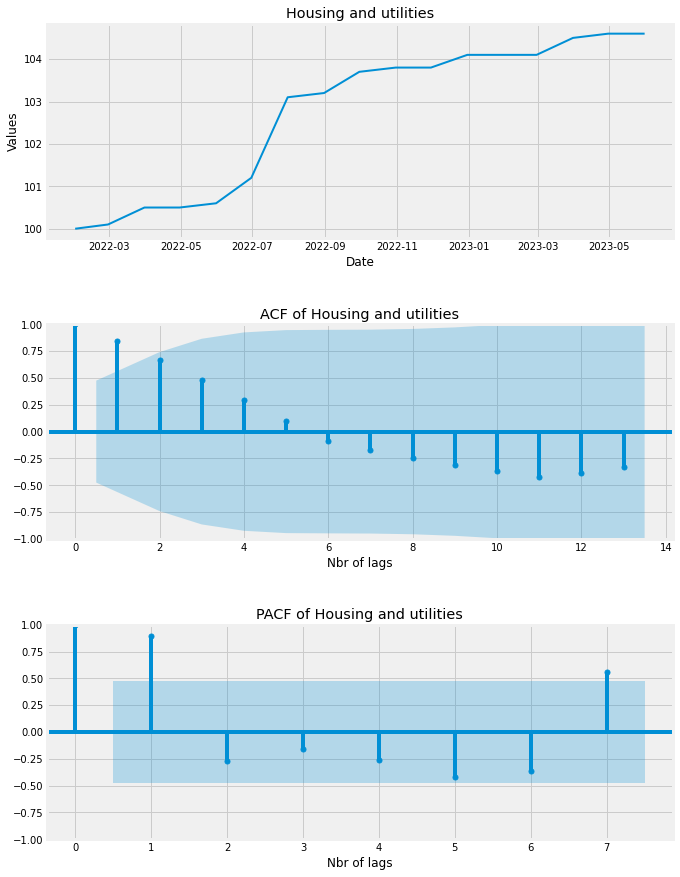

In [40]:
tsa_plots(housing_utilities)

In [41]:
ADF_test(housing_utilities.Value)

--------------- Test Results ---------------
The t-test: 	 -1.4185974940991446
The p-value: 	 0.5733284889978079
----------------------------------------------
The Time Serie is Not Stationary


In [42]:
ADF_test(housing_utilities.Value.diff(2).dropna())

--------------- Test Results ---------------
The t-test: 	 -2.352698754805404
The p-value: 	 0.1555340916748511
----------------------------------------------
The Time Serie is Not Stationary


In [43]:
model = arimax_model(housing_utilities, (1,1,0),exog_features="Vol (Rmill) 2")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -5.155
Date:                Mon, 24 Jul 2023   AIC                             16.310
Time:                        19:50:15   BIC                             18.628
Sample:                    01-31-2022   HQIC                            16.429
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Vol (Rmill) 2     0.0245      0.008      3.154      0.002       0.009       0.040
ar.L1             0.6359      0.276      2.305      0.021       0.095       1.177
sigma2            0.1080      0.072      1.501      0.133      -0.033       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.63   Prob(JB):                         0.90
Heteroskedasticity (H):               0.47   Skew:                             0.07
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -5.273
Date:                Mon, 24 Jul 2023   AIC                             16.546
Time:                        19:50:15   BIC                             18.670
Sample:                    01-31-2022   HQIC                            16.523
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Vol (Rmill) 2     0.0247      0.008      3.146      0.002       0.009       0.040
ar.L1             0.6304      0.280      2.253      0.024       0.082       1.179
sigma2            0.1143      0.084      1.363      0.173      -0.050       0.279
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.65   Prob(JB):                         0.85
Heteroskedasticity (H):               0.74   Skew:                             0.05
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 104.6
The predicted value: 	 104.48171088519055
The Error:         	 0.11828911480944271


In [44]:
testing_features(housing_utilities,(1,1,0))

For the SABOR (%) feature:
LLR = -11.409124773113197 	 AIC = 28.818249546226394 	 BIC = 31.136015712945735 	 Error = -0.135 

For the Vol (Rmill) 1 feature:
LLR = -11.206774151005888 	 AIC = 28.413548302011776 	 BIC = 30.73131446873112 	 Error = -0.137 

For the FX (%)  feature:
LLR = -9.499366336855175 	 AIC = 24.99873267371035 	 BIC = 27.316498840429695 	 Error = 0.129 

For the Vol (Rmill) 2 feature:
LLR = -5.155132828903174 	 AIC = 16.310265657806347 	 BIC = 18.628031824525692 	 Error = 0.118 



In [45]:
exog_df = df["Vol (Rmill) 2"][0]
cpi_dict["Housing and utilities"] = making_prediction(model,exog_df)

## 6. Household contents and services

In [46]:
household_services = df[df["Category"]== "Household contents and services"]
household_services = household_services.asfreq("M")
household_services.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Household contents and services,100.4,0.4,3.865,36.634,6.600,4.380
2022-02-28,Household contents and services,100.4,0.0,4.041,51.326,5.250,5.237
2022-03-31,Household contents and services,100.8,0.4,4.068,56.201,5.058,3.390
2022-04-30,Household contents and services,101.1,0.3,4.243,53.542,4.241,8.107
2022-05-31,Household contents and services,101.8,0.7,4.272,47.676,5.250,4.997


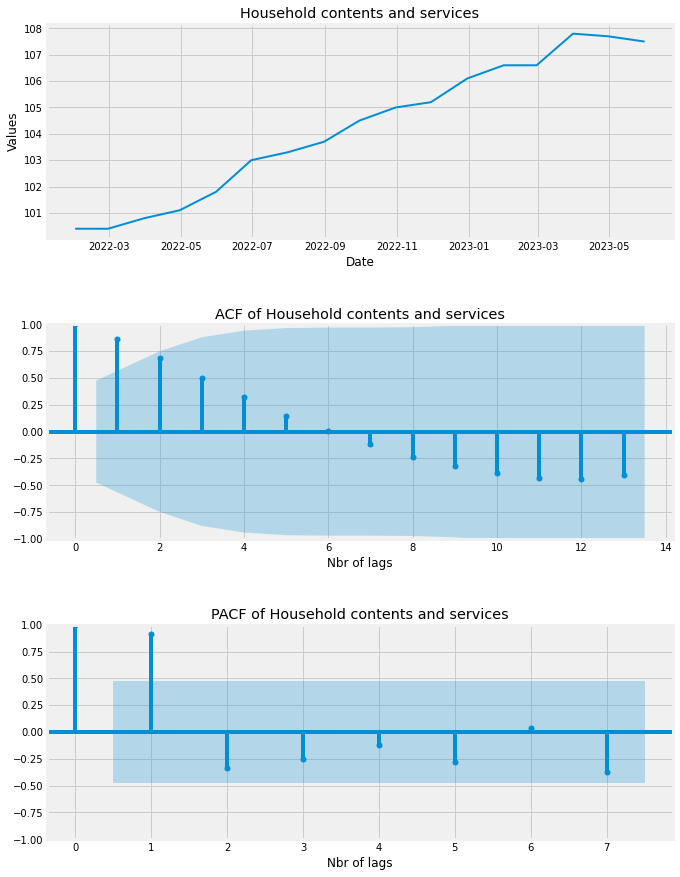

In [47]:
tsa_plots(household_services)

In [48]:
ADF_test(household_services.Value)

--------------- Test Results ---------------
The t-test: 	 -1.1766465931565537
The p-value: 	 0.6835602291839783
----------------------------------------------
The Time Serie is Not Stationary


In [49]:
ADF_test(household_services.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 -3.730255448258979
The p-value: 	 0.003707160129222103
----------------------------------------------
The Time Serie is Stationary


In [50]:
model = arimax_model(household_services, order=(1,1,1),exog_features="FX (%) ")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -10.040
Date:                Mon, 24 Jul 2023   AIC                             28.080
Time:                        19:50:16   BIC                             31.170
Sample:                    01-31-2022   HQIC                            28.238
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FX (%)         0.0988      0.100      0.985      0.325      -0.098       0.295
ar.L1          0.9969      0.051     19.631      0.000       0.897       1.096
ma.L1         -0.9241      0.637     -1.452      0.147      -2.172       0.323
sigma2         0.1828      0.109      1.673      0.094      -0.031       0.397
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.58   Prob(JB):                         0.75
Heteroskedasticity (H):               2.41   Skew:                            -0.18
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -8.350
Date:                Mon, 24 Jul 2023   AIC                             24.699
Time:                        19:50:17   BIC                             27.532
Sample:                    01-31-2022   HQIC                            24.669
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FX (%)         0.1247      0.087      1.436      0.151      -0.046       0.295
ar.L1          1.0000      0.055     18.315      0.000       0.893       1.107
ma.L1         -0.9937     12.946     -0.077      0.939     -26.366      24.379
sigma2         0.1452      1.889      0.077      0.939      -3.556       3.847
===================================================================================
Ljung-Box (L1) (Q):                   3.63   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.06   Prob(JB):                         0.79
Heteroskedasticity (H):               2.36   Skew:                            -0.11
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 107.5
The predicted value: 	 108.2624660633725
The Error:         	 -0.7624660633725


In [51]:
testing_features(household_services, (1,1,1))

For the SABOR (%) feature:
LLR = -10.312737770454804 	 AIC = 28.62547554090961 	 BIC = 31.71583042986873 	 Error = -0.631 

For the Vol (Rmill) 1 feature:
LLR = -10.571857305832076 	 AIC = 29.14371461166415 	 BIC = 32.23406950062328 	 Error = -0.684 

For the FX (%)  feature:
LLR = -10.039966623425162 	 AIC = 28.079933246850324 	 BIC = 31.17028813580945 	 Error = -0.762 

For the Vol (Rmill) 2 feature:
LLR = -10.556220413014568 	 AIC = 29.112440826029136 	 BIC = 32.20279571498826 	 Error = -0.666 



In [52]:
exog_df = df["FX (%) "][0]
cpi_dict["Household contents and services"] = making_prediction(model,exog_df)

## 7. Health

In [53]:
health = df[df["Category"]== "Health"]
health = health.asfreq("M")
health.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Health,100.1,0.1,3.865,36.634,6.600,4.380
2022-02-28,Health,103.2,3.1,4.041,51.326,5.250,5.237
2022-03-31,Health,103.7,0.5,4.068,56.201,5.058,3.390
2022-04-30,Health,104.0,0.3,4.243,53.542,4.241,8.107
2022-05-31,Health,104.3,0.3,4.272,47.676,5.250,4.997


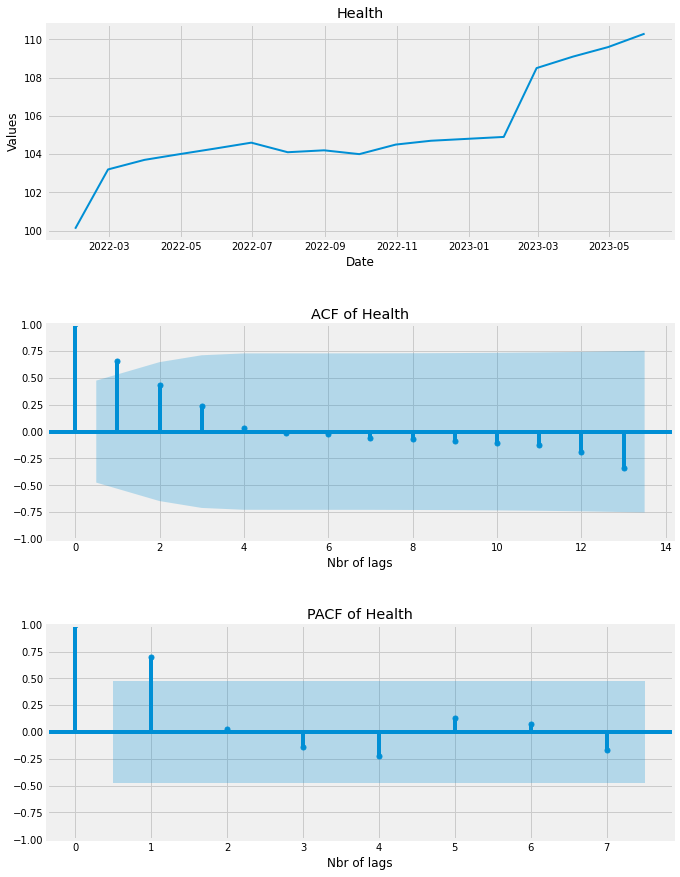

In [54]:
tsa_plots(health)

In [55]:
ADF_test(health.Value)

--------------- Test Results ---------------
The t-test: 	 -0.9142595447007883
The p-value: 	 0.7832402817751474
----------------------------------------------
The Time Serie is Not Stationary


In [56]:
ADF_test(health.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 -4.396002345678172
The p-value: 	 0.0003017056526545345
----------------------------------------------
The Time Serie is Stationary


In [57]:
model = arimax_model(health, (1,1,1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -25.130
Date:                Mon, 24 Jul 2023   AIC                             56.261
Time:                        19:50:20   BIC                             58.578
Sample:                    01-31-2022   HQIC                            56.379
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.204      4.896      0.000       0.600       1.400
ma.L1         -0.9917      6.609     -0.150      0.881     -13.946      11.962
sigma2         1.2299      8.233      0.149      0.881     -14.907      17.367
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.43
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             2.01
Prob(H) (two-sided):                  0.77   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -24.054
Date:                Mon, 24 Jul 2023   AIC                             54.108
Time:                        19:50:20   BIC                             56.232
Sample:                    01-31-2022   HQIC                            54.085
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.239      4.177      0.000       0.531       1.469
ma.L1         -0.9942      9.713     -0.102      0.918     -20.032      18.044
sigma2         1.3154     12.911      0.102      0.919     -23.990      26.621
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.71
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             1.94
Prob(H) (two-sided):                  0.77   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 110.3
The predicted value: 	 110.09528438079276
The Error:         	 0.20471561920723502


In [58]:
testing_features(health, (1,1,1))

For the SABOR (%) feature:
LLR = -23.624008717105614 	 AIC = 55.24801743421123 	 BIC = 58.338372323170354 	 Error = 0.152 

For the Vol (Rmill) 1 feature:
LLR = -24.19142389574166 	 AIC = 56.38284779148332 	 BIC = 59.47320268044245 	 Error = 0.412 

For the FX (%)  feature:
LLR = -25.12921319021454 	 AIC = 58.25842638042908 	 BIC = 61.348781269388205 	 Error = 0.215 

For the Vol (Rmill) 2 feature:
LLR = -25.146975766619697 	 AIC = 58.293951533239394 	 BIC = 61.38430642219852 	 Error = 0.074 



In [59]:
cpi_dict["Health"] = making_prediction(model)

## 8. Transport

In [60]:
transport = df[df["Category"]== "Transport"]
transport = transport.asfreq("M")
transport.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Transport,98.9,-1.1,3.865,36.634,6.600,4.380
2022-02-28,Transport,100.6,1.7,4.041,51.326,5.250,5.237
2022-03-31,Transport,103.7,3.1,4.068,56.201,5.058,3.390
2022-04-30,Transport,105.1,1.4,4.243,53.542,4.241,8.107
2022-05-31,Transport,105.9,0.8,4.272,47.676,5.250,4.997


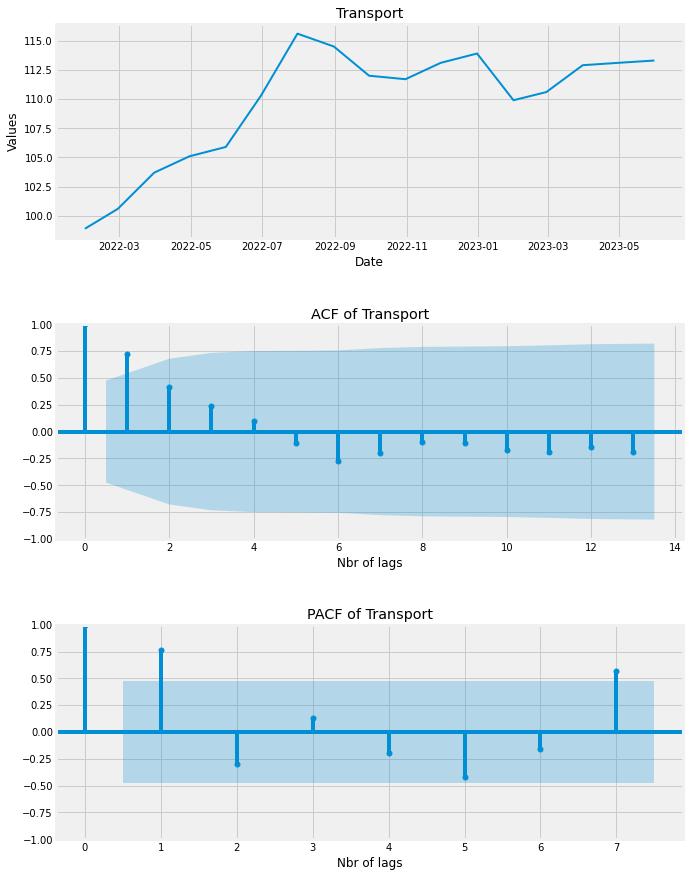

In [61]:
tsa_plots(transport)

In [62]:
ADF_test(transport.Value)

--------------- Test Results ---------------
The t-test: 	 -2.582479029527635
The p-value: 	 0.09667283546046124
----------------------------------------------
The Time Serie is Not Stationary


In [63]:
ADF_test(transport.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 -2.916921680493833
The p-value: 	 0.04341532589369273
----------------------------------------------
The Time Serie is Stationary


In [64]:
model = arimax_model(transport, (1,1,1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -34.028
Date:                Mon, 24 Jul 2023   AIC                             74.056
Time:                        19:50:23   BIC                             76.374
Sample:                    01-31-2022   HQIC                            74.175
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2498      0.352     -0.709      0.478      -0.940       0.440
ma.L1          0.9988     60.646      0.016      0.987    -117.866     119.864
sigma2         3.5581    215.749      0.016      0.987    -419.302     426.418
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.77   Prob(JB):                         0.85
Heteroskedasticity (H):               1.02   Skew:                            -0.28
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -32.372
Date:                Mon, 24 Jul 2023   AIC                             70.744
Time:                        19:50:23   BIC                             72.868
Sample:                    01-31-2022   HQIC                            70.721
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2387      0.368     -0.649      0.516      -0.959       0.482
ma.L1          0.9985     50.078      0.020      0.984     -97.152      99.149
sigma2         3.7619    188.336      0.020      0.984    -365.370     372.894
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.78   Prob(JB):                         0.79
Heteroskedasticity (H):               1.02   Skew:                            -0.40
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 113.3
The predicted value: 	 113.99003636295934
The Error:         	 -0.6900363629593471


In [65]:
testing_features(transport, (1,1,1))

For the SABOR (%) feature:
LLR = -33.57374778878598 	 AIC = 75.14749557757196 	 BIC = 78.23785046653109 	 Error = -0.126 

For the Vol (Rmill) 1 feature:
LLR = -34.02609590738699 	 AIC = 76.05219181477398 	 BIC = 79.1425467037331 	 Error = -0.696 

For the FX (%)  feature:
LLR = -33.87129069885597 	 AIC = 75.74258139771194 	 BIC = 78.83293628667107 	 Error = -0.532 

For the Vol (Rmill) 2 feature:
LLR = -34.0141304836817 	 AIC = 76.0282609673634 	 BIC = 79.11861585632252 	 Error = -0.654 



In [66]:
cpi_dict["Transport"] = making_prediction(model)

## 9. Communication

In [67]:
communication = df[df["Category"]== "Communication"]
communication = communication.asfreq("M")
communication.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Communication,99.8,-0.2,3.865,36.634,6.600,4.380
2022-02-28,Communication,99.7,-0.1,4.041,51.326,5.250,5.237
2022-03-31,Communication,99.7,0.0,4.068,56.201,5.058,3.390
2022-04-30,Communication,99.6,-0.1,4.243,53.542,4.241,8.107
2022-05-31,Communication,99.9,0.3,4.272,47.676,5.250,4.997


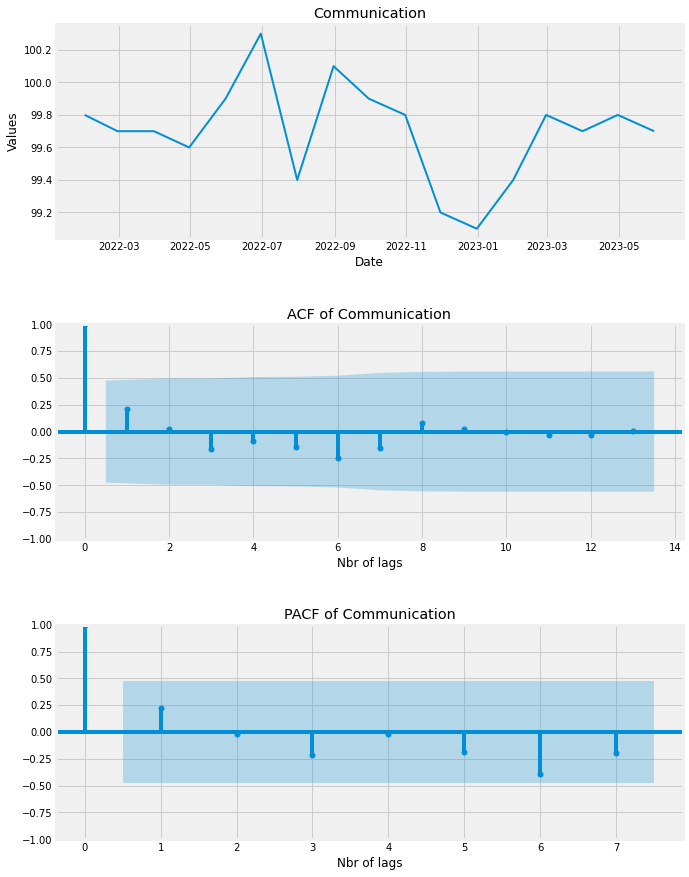

In [68]:
tsa_plots(communication)

In [69]:
ADF_test(communication.Value)

--------------- Test Results ---------------
The t-test: 	 -3.040347488141916
The p-value: 	 0.031294416774804976
----------------------------------------------
The Time Serie is Stationary


In [70]:
model = arimax_model(communication, (1,0,0),exog_features="Vol (Rmill) 2")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 0, 0)   Log Likelihood                   0.973
Date:                Mon, 24 Jul 2023   AIC                              6.053
Time:                        19:50:25   BIC                              9.386
Sample:                    01-31-2022   HQIC                             6.384
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            99.8903      0.165    604.509      0.000      99.566     100.214
Vol (Rmill) 2    -0.0221      0.015     -1.470      0.142      -0.052       0.007
ar.L1             0.6105      0.208      2.934      0.003       0.203       1.018
sigma2            0.0508      0.017      2.990      0.003       0.018       0.084
===================================================================================
Ljung-Box (L1) (Q):                   2.69   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.10   Prob(JB):                         0.65
Heteroskedasticity (H):               1.13   Skew:                            -0.49
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 0, 0)   Log Likelihood                   0.813
Date:                Mon, 24 Jul 2023   AIC                              6.375
Time:                        19:50:25   BIC                              9.465
Sample:                    01-31-2022   HQIC                             6.533
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            99.9269      0.209    478.097      0.000      99.517     100.337
Vol (Rmill) 2    -0.0232      0.018     -1.267      0.205      -0.059       0.013
ar.L1             0.6387      0.211      3.031      0.002       0.226       1.052
sigma2            0.0512      0.017      2.950      0.003       0.017       0.085
===================================================================================
Ljung-Box (L1) (Q):                   3.48   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.06   Prob(JB):                         0.52
Heteroskedasticity (H):               5.17   Skew:                            -0.61
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 99.7
The predicted value: 	 99.9149276150836
The Error:         	 -0.21492761508359592


In [71]:
testing_features(communication,(1,0,0))

For the SABOR (%) feature:
LLR = -2.489142649119443 	 AIC = 12.978285298238886 	 BIC = 16.31113867446375 	 Error = 0.095 

For the Vol (Rmill) 1 feature:
LLR = -2.531015154167789 	 AIC = 13.06203030833558 	 BIC = 16.394883684560444 	 Error = -0.058 

For the FX (%)  feature:
LLR = -1.5155972650992897 	 AIC = 11.03119453019858 	 BIC = 14.364047906423444 	 Error = -0.316 

For the Vol (Rmill) 2 feature:
LLR = 0.9734079624655356 	 AIC = 6.053184075068929 	 BIC = 9.386037451293793 	 Error = -0.215 



In [72]:
exog_df = df["Vol (Rmill) 2"][0]
cpi_dict["Communication"] = making_prediction(model,exog_df)

## 10. Recreation and culture

In [73]:
recreation_culture = df[df["Category"]== "Recreation and culture"]
recreation_culture = recreation_culture.asfreq("M")
recreation_culture.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Recreation and culture,100.2,0.2,3.865,36.634,6.600,4.380
2022-02-28,Recreation and culture,100.3,0.1,4.041,51.326,5.250,5.237
2022-03-31,Recreation and culture,100.4,0.1,4.068,56.201,5.058,3.390
2022-04-30,Recreation and culture,100.7,0.3,4.243,53.542,4.241,8.107
2022-05-31,Recreation and culture,101.0,0.3,4.272,47.676,5.250,4.997


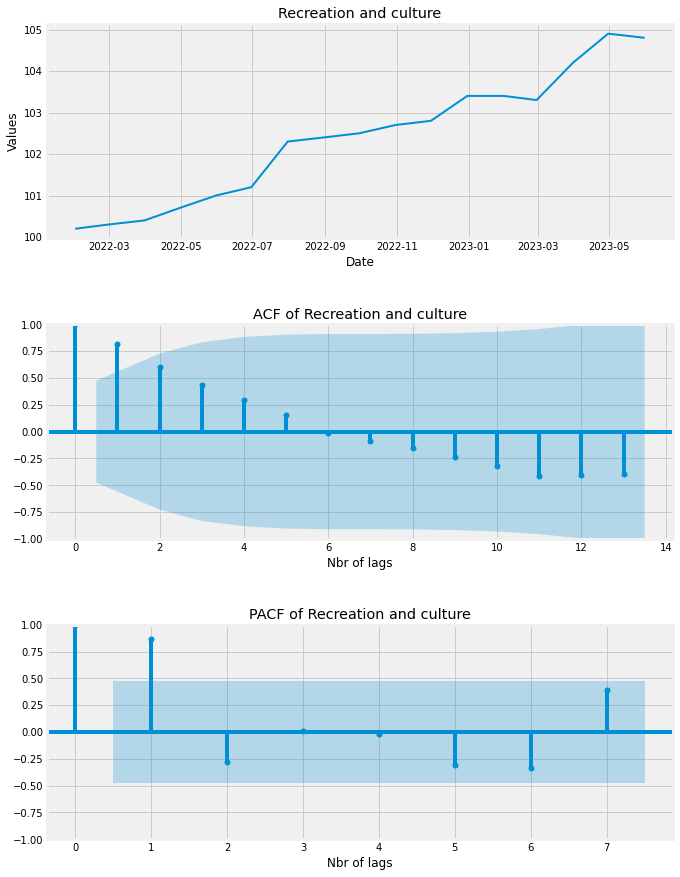

In [74]:
tsa_plots(recreation_culture)

In [75]:
ADF_test(recreation_culture.Value)

--------------- Test Results ---------------
The t-test: 	 -0.04245396120728459
The p-value: 	 0.9548771575252044
----------------------------------------------
The Time Serie is Not Stationary


In [76]:
ADF_test(recreation_culture.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 -3.211622402173141
The p-value: 	 0.019321708951738435
----------------------------------------------
The Time Serie is Stationary


In [77]:
model = arimax_model(recreation_culture, (1,1,1),exog_features="Vol (Rmill) 2")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -4.759
Date:                Mon, 24 Jul 2023   AIC                             17.519
Time:                        19:50:26   BIC                             20.609
Sample:                    01-31-2022   HQIC                            17.677
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Vol (Rmill) 2     0.0154      0.005      2.911      0.004       0.005       0.026
ar.L1             0.9999      0.055     18.159      0.000       0.892       1.108
ma.L1            -0.9902      4.714     -0.210      0.834     -10.230       8.250
sigma2            0.0907      0.449      0.202      0.840      -0.789       0.970
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.54   Prob(JB):                         0.63
Heteroskedasticity (H):              10.52   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         1.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -4.621
Date:                Mon, 24 Jul 2023   AIC                             17.241
Time:                        19:50:26   BIC                             20.074
Sample:                    01-31-2022   HQIC                            17.211
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Vol (Rmill) 2     0.0146      0.006      2.634      0.008       0.004       0.025
ar.L1             0.9998      0.064     15.688      0.000       0.875       1.125
ma.L1            -0.9824      3.327     -0.295      0.768      -7.502       5.538
sigma2            0.0921      0.332      0.277      0.782      -0.559       0.743
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.84   Prob(JB):                         0.71
Heteroskedasticity (H):              12.31   Skew:                            -0.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 104.8
The predicted value: 	 105.07915568734164
The Error:         	 -0.27915568734164253


In [78]:
testing_features(recreation_culture,(1,1,1))

For the SABOR (%) feature:
LLR = -8.289876400699645 	 AIC = 24.57975280139929 	 BIC = 27.670107690358414 	 Error = -0.394 

For the Vol (Rmill) 1 feature:
LLR = -7.1592132854450865 	 AIC = 22.318426570890175 	 BIC = 25.408781459849298 	 Error = -0.418 

For the FX (%)  feature:
LLR = -6.764862965515224 	 AIC = 21.52972593103045 	 BIC = 24.620080819989575 	 Error = -0.339 

For the Vol (Rmill) 2 feature:
LLR = -4.7592868362799 	 AIC = 17.5185736725598 	 BIC = 20.608928561518923 	 Error = -0.279 



In [79]:
exog_df = df["Vol (Rmill) 2"][0]
cpi_dict["Recreation and culture"] = making_prediction(model,exog_df)

## 11. Education

In [80]:
education = df[df["Category"]== "Education"]
education = education.asfreq("M")
education.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Education,100.0,0.0,3.865,36.634,6.600,4.380
2022-02-28,Education,100.0,0.0,4.041,51.326,5.250,5.237
2022-03-31,Education,104.4,4.4,4.068,56.201,5.058,3.390
2022-04-30,Education,104.4,0.0,4.243,53.542,4.241,8.107
2022-05-31,Education,104.4,0.0,4.272,47.676,5.250,4.997


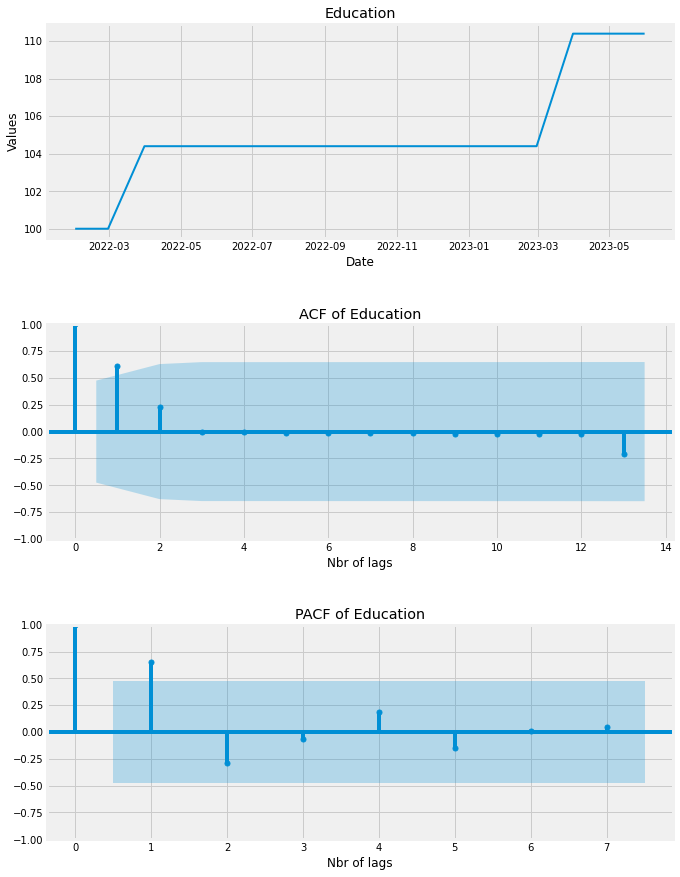

In [81]:
tsa_plots(education)

In [82]:
ADF_test(education.Value)

--------------- Test Results ---------------
The t-test: 	 -1.1471622544172329
The p-value: 	 0.6959026196905989
----------------------------------------------
The Time Serie is Not Stationary


In [83]:
model = arimax_model(education,(1,1,1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -32.633
Date:                Mon, 24 Jul 2023   AIC                             71.266
Time:                        19:50:28   BIC                             73.584
Sample:                    01-31-2022   HQIC                            71.385
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       3.418e-05   1.55e-08   2211.146      0.000    3.41e-05    3.42e-05
ma.L1      -3.418e-05   1.55e-08  -2211.000      0.000   -3.42e-05   -3.41e-05
sigma2         3.4600      0.623      5.558      0.000       2.240       4.680
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                25.34
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             2.39
Prob(H) (two-sided):                  0.51   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+31. Standard errors may be unstable.
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -31.078
Date:                Mon, 24 Jul 2023   AIC                             68.155
Time:                        19:50:28   BIC                             70.279
Sample:                    01-31-2022   HQIC                            68.133
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       3.941e-05   4.39e+06   8.97e-12      1.000   -8.61e+06    8.61e+06
ma.L1       -3.94e-05   4.39e+06  -8.97e-12      1.000   -8.61e+06    8.61e+06
sigma2         3.6906      1.077      3.425      0.001       1.579       5.802
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                20.02
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             2.27
Prob(H) (two-sided):                  0.51   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+16. Standard errors may be unstable.
"""

The test value:   	 110.4
The predicted value: 	 110.40000000000245
The Error:         	 -2.4442670110147446e-12


In [84]:
cpi_dict["Education"] = making_prediction(model)

## 12. Restaurants and hotels

In [85]:
restaurants_hotels = df[df["Category"]== "Restaurants and hotels "]
restaurants_hotels = restaurants_hotels.asfreq("M")
restaurants_hotels.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Restaurants and hotels,101.2,1.2,3.865,36.634,6.600,4.380
2022-02-28,Restaurants and hotels,101.9,0.7,4.041,51.326,5.250,5.237
2022-03-31,Restaurants and hotels,103.0,1.1,4.068,56.201,5.058,3.390
2022-04-30,Restaurants and hotels,103.3,0.3,4.243,53.542,4.241,8.107
2022-05-31,Restaurants and hotels,103.8,0.5,4.272,47.676,5.250,4.997


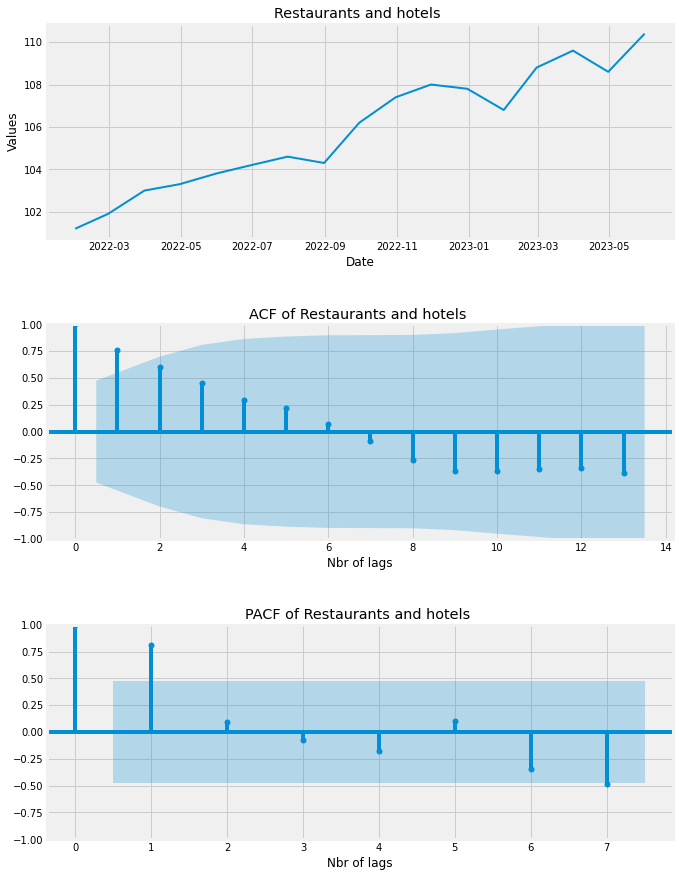

In [86]:
tsa_plots(restaurants_hotels)

In [87]:
ADF_test(restaurants_hotels.Value)

--------------- Test Results ---------------
The t-test: 	 -0.7404807909497473
The p-value: 	 0.8359836866203985
----------------------------------------------
The Time Serie is Not Stationary


In [88]:
ADF_test(restaurants_hotels.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 -2.749319636008497
The p-value: 	 0.06588567960784467
----------------------------------------------
The Time Serie is Not Stationary


In [89]:
model = arimax_model(restaurants_hotels, (1,0,1),exog_features="SABOR (%)")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -19.034
Date:                Mon, 24 Jul 2023   AIC                             48.069
Time:                        19:50:29   BIC                             52.235
Sample:                    01-31-2022   HQIC                            48.483
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.1067      0.557    170.706      0.000      94.015      96.199
SABOR (%)      1.8944      0.100     18.923      0.000       1.698       2.091
ar.L1          0.4093      0.500      0.818      0.413      -0.571       1.390
ma.L1         -0.9981     32.530     -0.031      0.976     -64.757      62.760
sigma2         0.4866     15.722      0.031      0.975     -30.327      31.300
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.54   Prob(JB):                         0.80
Heteroskedasticity (H):               0.86   Skew:                             0.12
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -18.340
Date:                Mon, 24 Jul 2023   AIC                             46.679
Time:                        19:50:29   BIC                             50.542
Sample:                    01-31-2022   HQIC                            46.877
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.1755      0.745    127.768      0.000      93.716      96.636
SABOR (%)      1.8800      0.138     13.629      0.000       1.610       2.150
ar.L1          0.4540      0.531      0.855      0.393      -0.587       1.495
ma.L1         -0.9997    215.700     -0.005      0.996    -423.764     421.765
sigma2         0.5133    110.610      0.005      0.996    -216.279     217.306
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.48   Prob(JB):                         0.77
Heteroskedasticity (H):               0.78   Skew:                             0.17
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 110.4
The predicted value: 	 109.98720440200147
The Error:         	 0.4127955979985387


In [90]:
testing_features(restaurants_hotels,(1,0,1))

For the SABOR (%) feature:
LLR = -19.034289713089596 	 AIC = 48.06857942617919 	 BIC = 52.23464614646027 	 Error = 0.413 

For the Vol (Rmill) 1 feature:
LLR = -26.242160668285333 	 AIC = 62.484321336570666 	 BIC = 66.65038805685174 	 Error = 2.385 

For the FX (%)  feature:
LLR = -26.231032947085303 	 AIC = 62.46206589417061 	 BIC = 66.62813261445169 	 Error = 2.546 

For the Vol (Rmill) 2 feature:
LLR = -26.23287991396476 	 AIC = 62.46575982792952 	 BIC = 66.6318265482106 	 Error = 2.501 



In [91]:
exog_df = df["SABOR (%)"][0]
cpi_dict["Restaurants and hotels "] = making_prediction(model,exog_df)

## 13. Miscellaneous goods and service

In [92]:
goods_services = df[df["Category"]== "Miscellaneous goods and services"]
goods_services = goods_services.asfreq("M")
goods_services.head()

,Category,Value,Percentage_Change,SABOR (%),Vol (Rmill) 1,FX (%),Vol (Rmill) 2
Date,,,,,,,
2022-01-31,Miscellaneous goods and services,100.6,0.6,3.865,36.634,6.600,4.380
2022-02-28,Miscellaneous goods and services,101.5,0.9,4.041,51.326,5.250,5.237
2022-03-31,Miscellaneous goods and services,101.9,0.4,4.068,56.201,5.058,3.390
2022-04-30,Miscellaneous goods and services,102.8,0.9,4.243,53.542,4.241,8.107
2022-05-31,Miscellaneous goods and services,102.9,0.1,4.272,47.676,5.250,4.997


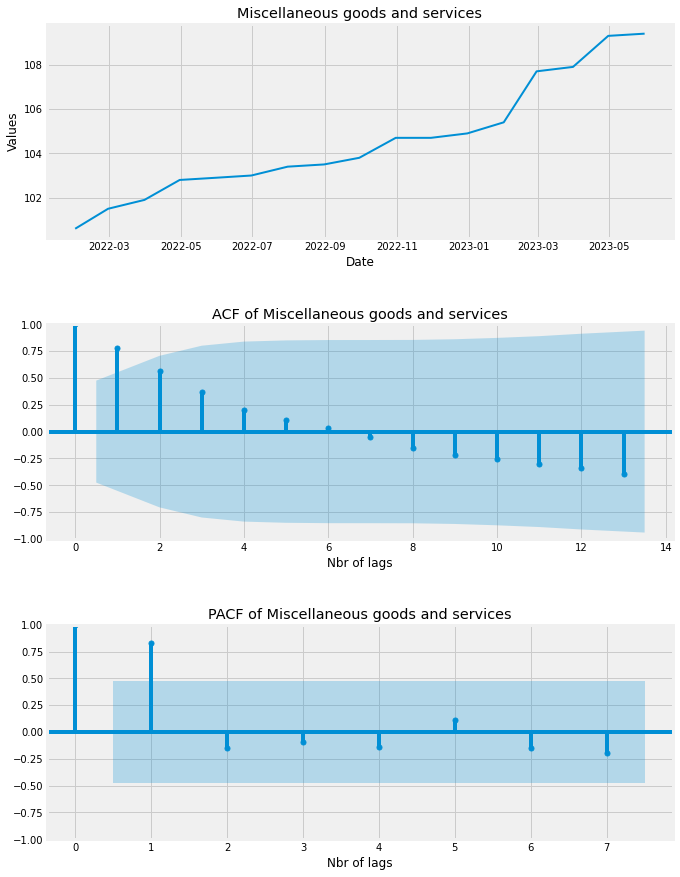

In [93]:
tsa_plots(goods_services)

In [94]:
ADF_test(goods_services.Value)

--------------- Test Results ---------------
The t-test: 	 4.05932777738601
The p-value: 	 1.0
----------------------------------------------
The Time Serie is Not Stationary


In [95]:
ADF_test(goods_services.Value.diff().dropna())

--------------- Test Results ---------------
The t-test: 	 2.889477526215954
The p-value: 	 1.0
----------------------------------------------
The Time Serie is Not Stationary


In [96]:
model = arimax_model(goods_services, (1,1,1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -16.129
Date:                Mon, 24 Jul 2023   AIC                             38.258
Time:                        19:50:31   BIC                             40.576
Sample:                    01-31-2022   HQIC                            38.377
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.052     19.166      0.000       0.898       1.102
ma.L1         -0.9917      4.615     -0.215      0.830     -10.036       8.053
sigma2         0.3779      1.696      0.223      0.824      -2.947       3.703
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):                 8.17
Prob(Q):                              0.26   Prob(JB):                         0.02
Heteroskedasticity (H):               5.14   Skew:                             1.49
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------ TEST: ------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -15.426
Date:                Mon, 24 Jul 2023   AIC                             36.851
Time:                        19:50:31   BIC                             38.975
Sample:                    01-31-2022   HQIC                            36.829
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9962      0.073     13.665      0.000       0.853       1.139
ma.L1         -0.9213      0.704     -1.308      0.191      -2.302       0.459
sigma2         0.4088      0.238      1.719      0.086      -0.057       0.875
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 7.28
Prob(Q):                              0.39   Prob(JB):                         0.03
Heteroskedasticity (H):               5.05   Skew:                             1.47
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The test value:   	 109.4
The predicted value: 	 109.87736433387673
The Error:         	 -0.4773643338767215


In [97]:
testing_features(goods_services,(1,1,1))

For the SABOR (%) feature:
LLR = -15.860040384260486 	 AIC = 39.72008076852097 	 BIC = 42.8104356574801 	 Error = -0.367 

For the Vol (Rmill) 1 feature:
LLR = -16.11016097663694 	 AIC = 40.22032195327388 	 BIC = 43.31067684223301 	 Error = -0.518 

For the FX (%)  feature:
LLR = -15.972687783773377 	 AIC = 39.945375567546755 	 BIC = 43.03573045650588 	 Error = -0.466 

For the Vol (Rmill) 2 feature:
LLR = -16.10566472247302 	 AIC = 40.21132944494604 	 BIC = 43.301684333905165 	 Error = -0.427 



In [98]:
cpi_dict["Miscellaneous goods and services"] = making_prediction(model)

# V. Making Predictions

In [99]:
cpi_predictions = pd.DataFrame(list(cpi_dict.items()), columns=['ID', 'Value'])
cpi_predictions

,ID,Value
0,Headline_CPI,110.085237
1,Food and non-alcoholic beverages,117.930829
2,Alcoholic beverages and tobacco,110.897174
3,Clothing and footwear,104.293961
4,Housing and utilities,104.714690
5,Household contents and services,107.876602
6,Health,110.818001
7,Transport,112.612150
8,Communication,99.733098
9,Recreation and culture,105.067648


In [100]:
ss = pd.read_csv("June_SampleSubmission.csv")
ss["Value"] = cpi_dict.values()
ss.to_csv('Zindi_CPI_Predictions_June.csv', index = 0)